# Deep Reinforcement Learning Nanodegree
# Project 2 --- Continous Control :
---

In this notebook, I will show how to launch an Unity ML environment, to (1) train a single and (2) twenty robotic arms at a time to move towards a target location. This project is part of [Udacity's Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment
---

First, install the required python packages (when running in Udacity Workspaces). In case of returning an error, recheck dependencies and assure you have installed [Unity ML agents and environments](https://github.com/Unity-Technologies/ml-agents) correctly.

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.2799999937415123


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## 5. Create training function

In [6]:
from Hyperparameters import *
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


TARGET_SCORE = 30

def single_runner(agent, env, n_episodes=N_EPISODES, max_t=MAX_T, print_every=PRINT_EVERY):
    
    """ Function to run training for multiple agents
        ARGUMETNS
        =========
            - agent (object) = multiple agents
            - env (object) = Unity ML environment
            - n_episodes (int) = Number of training iterations
            - max_t (int) = maximum timesteps per iteration
            - print_every (int) = how often to output results
            
        RETURNS
        =======
            - scores (int) = scores made per episode
    """
    
    
    scores_deque = deque(maxlen=print_every)
    scores_list = []
    
    time_global_0 = time.time()
    for i_episode in range(1, n_episodes+1):
        
        time_episode_0 = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations[0]
        
        score = 0
        for t in range(1, max_t+1):
                
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
                
            agent.step(state, action, reward, next_state, done)
                    
            score += reward
            state = next_state

                
            if done:
                break
         
        scores_deque.append(score)
        scores_list.append(score)
        
        itertime = time.time() - time_episode_0
        elapsedtime = time.time() - time_global_0
        itertime_string = time.strftime('%Hh%Mm%Ss', time.gmtime(itertime))
        
        print('\rEpisode {}, {} ---> Score: {} \tRolling Average Score: {:.2f}\t' \
              "Average score: {}" \
              .format(i_episode, itertime_string, score, np.mean(scores_deque), 
                      np.around(np.mean(scores_list), decimals=2)))
        
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if np.mean(scores_deque) >= TARGET_SCORE:
            globaltime_string = time.strftime('%Hh%Mm%Ss', time.gmtime(elapsedtime))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            print("==============================================")
            print("Environment solved in {} episodes.\t" \
                  "Average score is: {:.2f}\tElapsed total time: {}".format(i_episode-PRINT_EVERY,
                                                                            np.mean(scores_deque),
                                                                            globaltime_string))
            print()
            print("\nSaving model ...", end="")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print("\nModel saved.")
            break

    return scores_list, scores_deque

## 6. Run training

Instantiate the agent as "td3_agent", then run training.
Store the resulting scores in a pandas dataframe and save as a csv-file.

In [7]:
import time
from TD3_Agent import TD3

td3_agent = TD3(state_size=state_size, action_size=action_size, random_seed=10)

In [8]:
td3_scores_list, td3_scores_deque = single_runner(td3_agent, env)

# store results in a pandas dataframe
import pandas as pd

td3_df = pd.DataFrame(td3_scores_list)
td3_df.to_csv('td3_scores_list.csv', index=False, header=True)

Episode 1, 00h00m15s ---> Score: 0.3499999921768904 	Rolling Average Score: 0.35	Average score: 0.35
Episode 2, 00h00m20s ---> Score: 0.2299999948590994 	Rolling Average Score: 0.29	Average score: 0.29
Episode 3, 00h00m20s ---> Score: 0.40999999083578587 	Rolling Average Score: 0.33	Average score: 0.33
Episode 4, 00h00m20s ---> Score: 0.6499999854713678 	Rolling Average Score: 0.41	Average score: 0.41
Episode 5, 00h00m20s ---> Score: 0.0 	Rolling Average Score: 0.33	Average score: 0.33
Episode 6, 00h00m20s ---> Score: 0.5599999874830246 	Rolling Average Score: 0.37	Average score: 0.37
Episode 7, 00h00m20s ---> Score: 0.25999999418854713 	Rolling Average Score: 0.35	Average score: 0.35
Episode 8, 00h00m20s ---> Score: 2.0899999532848597 	Rolling Average Score: 0.57	Average score: 0.57
Episode 9, 00h00m20s ---> Score: 0.3899999912828207 	Rolling Average Score: 0.55	Average score: 0.55
Episode 10, 00h00m20s ---> Score: 0.8299999814480543 	Rolling Average Score: 0.58	Average score: 0.58
Ep

## 7. Plot results

In [11]:
import pandas as pd
td3_scores = pd.read_csv("td3_scores_list.csv")

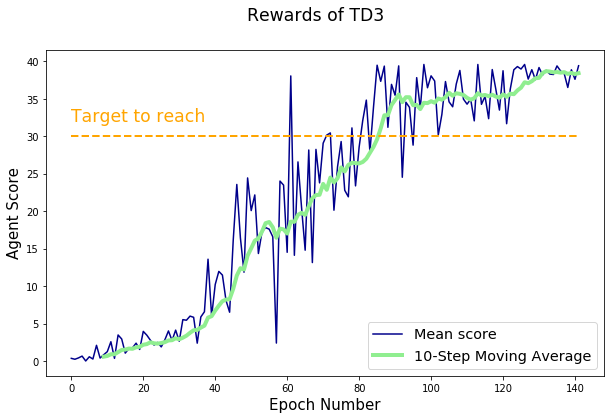

In [12]:
import matplotlib.pyplot as plt
import numpy as np

mean_scores = np.mean(td3_scores, 1)
rolling_average_mean = pd.Series(mean_scores).rolling(10).mean()
target_line = [TARGET_SCORE] * len(td3_scores)

fig = plt.figure(figsize=[10,6])
fig.suptitle("Rewards of TD3", fontsize="xx-large")

axis = fig.add_subplot(111)

axis.plot(td3_scores, label="Mean score", color="DarkBlue")
axis.plot(rolling_average_mean, label="10-Step Moving Average", color="LightGreen", linewidth=4)
axis.plot(target_line, linestyle="--", color="Orange", linewidth=2)

axis.text(0, TARGET_SCORE+2, "Target to reach", color="Orange", fontsize="xx-large")

axis.set_ylabel("Agent Score", fontsize=15)
axis.set_xlabel("Epoch Number", fontsize=15)

axis.legend(fontsize="x-large", loc="lower right");

# Train Multiple Agents
---

## 1. Create training function for multiple agents

In [1]:
from Hyperparameters import *
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


TARGET_SCORE = 30

def multi_runner(agent, env, n_episodes=N_EPISODES, max_t=MAX_T, print_every=PRINT_EVERY):
    
    """ Function to run training for multiple agents
        ARGUMETNS
        =========
            - agent (object) = multiple agents
            - env (object) = Unity ML environment
            - n_episodes (int) = Number of training iterations
            - max_t (int) = maximum timesteps per iteration
            - print_every (int) = how often to output results
            
        RETURNS
        =======
            - scores (int) = scores made per episode
    """
    
    
    scores_deque = deque(maxlen=print_every)
    scores_list = []
    
    time_global_0 = time.time()
    for i_episode in range(1, n_episodes+1):
        
        time_episode_0 = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        states = env_info.vector_observations
        
        scores = np.zeros(num_agents)
        for t in range(1, max_t+1):
                
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
                
            for (state, action, reward, next_state, done) \
                    in zip(states, actions, rewards, next_states, dones):
                    agent.step(state, action, reward, next_state, done)
            
            scores += rewards
            states = next_states
                
            if np.any(dones):
                break
         
        scores_deque.append(np.mean(scores))
        scores_list.append(scores.tolist())
        
        itertime = time.time() - time_episode_0
        elapsedtime = time.time() - time_global_0
        itertime_string = time.strftime('%Hh%Mm%Ss', time.gmtime(itertime))
        
        print('\rEpisode {}, {}\tRolling Average Score: {:.2f}\t' \
              "Average score: {} (High: {} , Low {})" \
              .format(i_episode, itertime_string, np.mean(scores_deque), 
                      np.mean(scores), scores.max(), scores.min()))
        print("Global Score Average: {}".format(np.mean(scores_list)))
        
        print("========================================================================================")
        
        if np.mean(scores_deque) >= TARGET_SCORE:
            globaltime_string = time.strftime('%Hh%Mm%Ss', time.gmtime(elapsedtime))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            print("==============================================")
            print("Environment solved in {} episodes.\t" \
                  "Average score is: {:.2f}\tElapsed total time: {}".format(i_episode-PRINT_EVERY,
                                                                            np.mean(scores_deque),
                                                                            globaltime_string))
            print("\nSaving model ...", end="")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_multiactor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_multicritic.pth')
            print("\nModel saved.")
            break

    return scores_list, scores_deque

## 2. Restart environment

In [2]:
!pip -q install ./python

# imports 
from unityagents import UnityEnvironment
import numpy as np

# load env with 20 agents
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


## 3. Set up 20 agents and train

In [3]:
import time
import pandas as pd

from TD3_Agent import TD3

# create agent
multi_td3_agent = TD3(state_size=state_size, action_size=action_size, random_seed=10)

In [4]:
# run training and store results
multi_td3_scores_list, multi_td3_scores_deque = multi_runner(multi_td3_agent, env)


Episode 1, 00h05m24s	Rolling Average Score: 1.09	Average score: 1.087999975681305 (High: 2.3099999483674765 , Low 0.06999999843537807)
Global Score Average: 1.087999975681305
Episode 2, 00h05m30s	Rolling Average Score: 2.85	Average score: 4.60999989695847 (High: 9.439999788999557 , Low 2.009999955072999)
Global Score Average: 2.8489999363198875
Episode 3, 00h05m31s	Rolling Average Score: 5.42	Average score: 10.566499763820321 (High: 17.599999606609344 , Low 4.909999890252948)
Global Score Average: 5.421499878820032
Episode 4, 00h05m33s	Rolling Average Score: 8.84	Average score: 19.110999572835862 (High: 28.73999935761094 , Low 11.079999752342701)
Global Score Average: 8.84387480232399
Episode 5, 00h05m35s	Rolling Average Score: 12.24	Average score: 25.808999423123897 (High: 37.87999915331602 , Low 19.409999566152692)
Global Score Average: 12.236899726483971
Episode 6, 00h05m36s	Rolling Average Score: 15.50	Average score: 31.818499288801103 (High: 37.95999915152788 , Low 24.729999447241

## 4. Visualise the data

In [5]:
# save as csv
multi_td3_df = pd.DataFrame(multi_td3_scores_list)
multi_td3_df.to_csv('multi_td3_scores_list.csv', index=False, header=True)

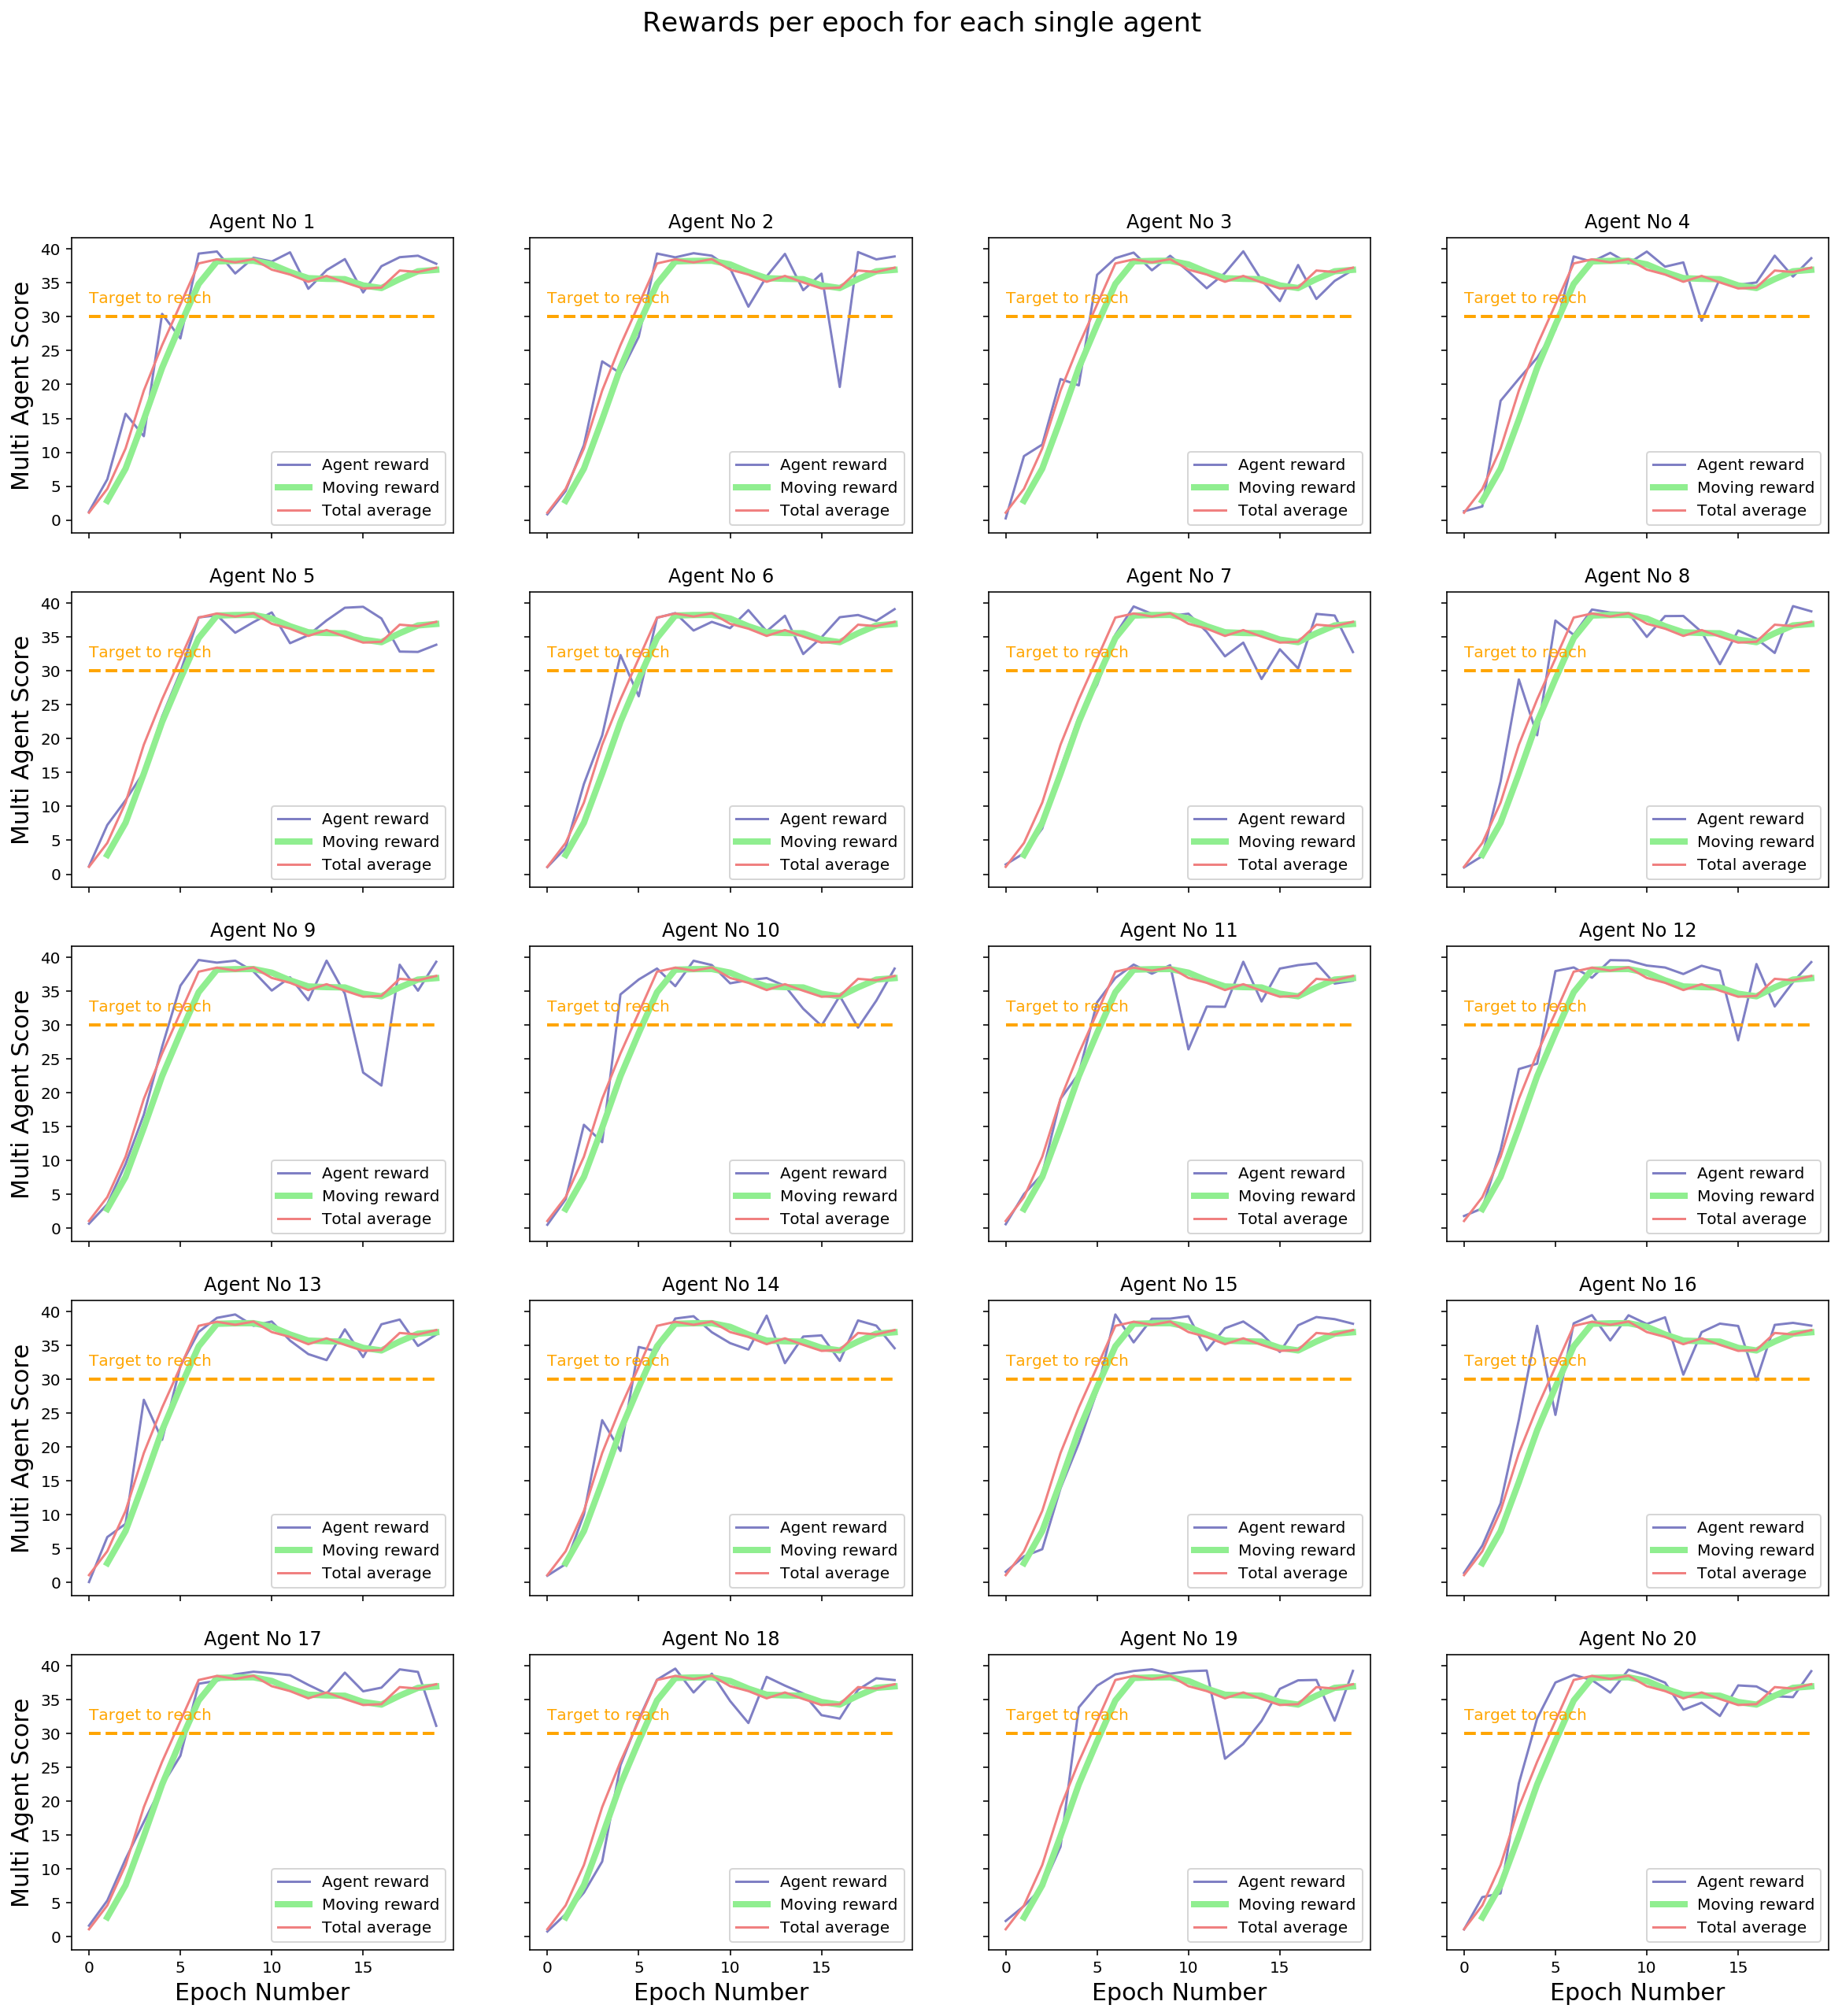

In [6]:
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline
%config InlineBackend.figure_format = "retina"

m_td3_scores = pd.read_csv("multi_td3_scores_list.csv")
scorelist = np.array(np.transpose(m_td3_scores))


mean_scores = np.mean(m_td3_scores, 1)
rolling_average_mean = pd.Series(mean_scores).rolling(2).mean()

target_line = [TARGET_SCORE] * len(m_td3_scores)


assert len(m_td3_scores) == 20, "Number of agents unequals requested number of agents"

fig, axis = plt.subplots(5,4, figsize=(20,20), sharex=True, sharey=True)
fig.suptitle("Rewards per epoch for each single agent", fontsize="xx-large")

axis = axis.flatten()
for index, (axis, score) in enumerate(zip(axis,scorelist)):
    axis.plot(score, label="Agent reward", color="DarkBlue", alpha=0.5)
    axis.plot(rolling_average_mean, label="Moving reward", color="LightGreen", linewidth=4)
    axis.plot(mean_scores, label="Total average", color="LightCoral")
    axis.plot(target_line, linestyle="--", color="Orange", linewidth=2)
    axis.text(0, TARGET_SCORE+2, "Target to reach", color="Orange", fontsize="medium")
    
    axis.legend(loc="lower right")

    axis.set_title("Agent No {}".format(index+1))
    axis.set_ylabel("Multi Agent Score", fontsize=15)
    axis.set_xlabel("Epoch Number", fontsize=15)
    axis.label_outer();
